# Imports

In [105]:
import pandas as pd
import numpy as np
import re
from datetime import timedelta
from connection_keys import connection
import statsmodels.api as sm

import warnings
import itertools
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.set_option('display.max_colwidth', None)

from utils import transforma_campo_str_int

### Conexão com o banco e captura os dados

In [35]:
connectionbd = connection('db_hardware')
query = """
    select * from graphic_card
"""
df = pd.read_sql(query, connectionbd)

### Apresentação de uma amostra dos dados e dos tipo em que estão vindo

In [3]:
print('Tipo dos campso')
display(df.dtypes)
print('Amostra')
display(df.sample(5))

Tipo dos campso


id                      int64
marca                  object
nome_produto           object
preco_antigo_cartao    object
preco_atual_cartao     object
preco_boleto           object
data                   object
hora                   object
loja                   object
disponibilidade        object
dtype: object

Amostra


,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade
18724,22218,Gigabyte,"Placa de Vídeo Gigabyte NVIDIA GeForce GTX 1650 D6 0C 4G, 4GB, GDDR6 - GV-N1656OC-4GD","1.364,59","1.182,24","1.004,90",2020-11-05,11:56:43,Kabum,Disponivel
11932,13107,Gigabyte,"Placa de Vídeo Gigabyte NVIDIA GeForce GTX 1060 WindForce 2X OC D5X 6G, GDDR5 - GV-N1060WF2OC-6GD 2.0",0,"1.294,00","1.099,90",2020-10-14,18:44:10,Kabum,Indisponivel
27959,32577,Zotac,"Placa de Vídeo Zotac NVIDIA GeForce RTX 3090 Trinity, 24GB, GDDR6X - ZT-A30900D-10P",0,"15.882,24","13.499,90",2020-11-25,18:20:25,Kabum,Indisponivel
1465,1466,Aorus,"Placa de Vídeo Gigabyte Aorus NVIDIA GeForce RTX 2080 Ti Xtreme Waterforce WB 11G, GDDR6 - GV-N208TAORUSX WB-11GC",0,"10.841,06","9.214,90",2020-09-14,18:27:27,Kabum,Indisponivel
4203,4204,Gigabyte,"Placa de Vídeo Gigabyte NVIDIA GeForce RTX 2070 Super Gaming OC 3x White, 8GB, GDDR6 - GV-N207SGAMINGOC WHITE-8GD",0,"4.705,76","3.999,90",2020-09-21,22:59:13,Kabum,Disponivel


### Modelagem dos campos para a analise

In [36]:
# df.apply(lambda x: concatena_numero_apolice_seguradora(x['insurerCode'], x['insurerPolicyNumber']),axis=1)
df['preco_antigo_cartao'] = df['preco_antigo_cartao'].str.replace('.', '').str.replace(',', '.').astype(float)
df['preco_atual_cartao'] = df['preco_atual_cartao'].str.replace('.', '').str.replace(',', '.').astype(float)
df['preco_boleto'] = df['preco_boleto'].str.replace('.', '').str.replace(',', '.').astype(float)
df['nome_produto'] = df['nome_produto'].str.upper()
df['marca'] = df['marca'].str.upper()
df['data_hora'] = pd.to_datetime(df['data'] + ' ' + df['hora'])
df['data'] = pd.to_datetime(df['data'])

#### Primeiro método para checar ruidos nos dados, a intenção é pegar oq não se enquadra como  placa de video

In [37]:
def get_resume_product_name(name):
    # string = df['nome_produto'][df['id'] == 259].item()
    pattern = "(RTX|GTX|GT|RX|WX|Quadro|R7|R5|R9|HD)(\d+)"
    resume_name = re.search(pattern, name.replace(" ", ""))
    if resume_name is None: 
        return '' 
    else: 
        return resume_name.group()

df['nome_produto_resumido'] = df.apply(lambda x: get_resume_product_name(x['nome_produto']), axis=1)

In [38]:
display(len(df.query('nome_produto_resumido == ""')))
df.query('nome_produto_resumido == ""')

2173

,id,marca,nome_produto,preco_antigo_cartao,preco_atual_cartao,preco_boleto,data,hora,loja,disponibilidade,data_hora,nome_produto_resumido
7,8,RISE MODE,SUPORTE PARA PLACA DE VÍDEO VGA RISE ATÉ 2 PLACAS RM-SV-01-BK,31.47,27.26,25.90,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
20,21,RISE MODE,SUPORTE PARA PLACA DE VÍDEO VGA RISE TRANSPARENTE RM-SV-01-AQ,39.89,28.78,25.90,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
28,29,RISE MODE,SUPORTE PARA PLACA DE VÍDEO RISE LV2 SMALL BLACK AND WHITE RM-SV-04-BW,54.00,44.59,37.90,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
37,38,RISE MODE,SUPORTE PARA PLACA DE VÍDEO VGA RISE ATÉ 2 PLACAS RM-SV-01-BK,31.47,27.26,25.90,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
50,51,RISE MODE,SUPORTE PARA PLACA DE VÍDEO VGA RISE TRANSPARENTE RM-SV-01-AQ,39.89,28.78,25.90,2020-09-10,19:12:39,Kabum,Disponivel,2020-09-10 19:12:39,
...,...,...,...,...,...,...,...,...,...,...,...,...
30523,35678,SAPPHIRE,"PLACA DE VÍDEO SAPPHIRE AMD RADEON GPRO 6200 4GB, GDDR5 - 32258-00-21G",0.00,1732.82,1472.90,2020-11-29,13:37:03,Kabum,Indisponivel,2020-11-29 13:37:03,
30646,35801,ASUS,CASE PARA PLACA DE VÍDEO ASUS ROG XG STATION 2 - 90YV09B1-M0SA00,0.00,4258.71,3619.90,2020-11-29,13:37:03,Kabum,Indisponivel,2020-11-29 13:37:03,
30682,35837,PNY,"PLACA DE VÍDEO PNY NVIDIA QUADRO P1000, 4GB, GDDR5 - VCQP1000V2-PB",0.00,3623.91,3080.32,2020-11-29,13:37:03,Kabum,Indisponivel,2020-11-29 13:37:03,
30726,35881,DEEPCOOL,SUPORTE PARA PLACA DE VÍDEO VGA DEEPCOOL - GH-01 RGB,0.00,70.47,59.90,2020-11-29,13:37:03,Kabum,Indisponivel,2020-11-29 13:37:03,


#### Drop dos dados que foram pegos na limpeza dos dados como não sendo placas de videos para analise

In [39]:
indexNames = df.query('nome_produto.str.contains("SUPORTE") | nome_produto.str.contains("CASE")').index
df.drop(indexNames , inplace=True)
del df['nome_produto_resumido']

# Analise

#### Verificando qual marca de placa de video tem em média o maior preço

In [40]:
df_marcas = df['preco_atual_cartao'].groupby(df['marca']).mean().sort_values(ascending=False)
print(df_marcas)

marca
AORUS         7161.044340
GAINWARD      5790.254347
AMD           5586.294887
COLORFUL      4905.248972
ASUS          3765.544049
PNY           3752.171018
EVGA          3709.625746
MSI           2975.529666
GALAX         2921.974869
ZOTAC         2686.607468
GIGABYTE      2610.143296
ASROCK        2367.220871
SAPPHIRE      2173.278554
XFX           2048.606217
POWERCOLOR    1758.442784
HUSKY          820.988235
PCYES          572.408645
AFOX           428.818277
ADATA          285.025000
Name: preco_atual_cartao, dtype: float64


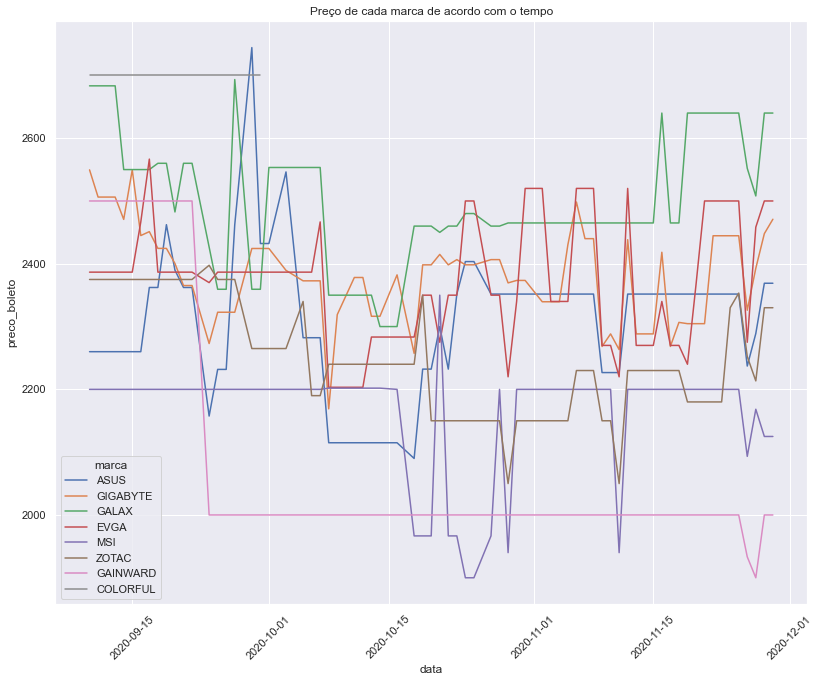

In [53]:
placa = 'RTX 2060'
analise = df.query(f'nome_produto.str.contains("{placa}") & (~nome_produto.str.contains("TI") & ~nome_produto.str.contains("SUPER"))')
# (analise['preco_atual_cartao'].groupby(analise['marca']).mean())
sns.set(rc={'figure.figsize':(12,10)})
plt.xticks(rotation = 45)
ax = sns.lineplot(
    x="data",
    y="preco_boleto",
    hue='marca',
    data=analise,
    ci=None,
    markers=True
).set_title('Preço de cada marca de acordo com o tempo');

In [10]:
# placa = 'RTX 2070 SUPER'
# analise = df.query(f'nome_produto.str.contains("{placa}")')
# plt.xticks(rotation = 45)
# # (analise['preco_atual_cartao'].groupby(analise['marca']).mean())
# sns.set(rc={'figure.figsize':(12,10)})
# ax = sns.lineplot(
#     x="data",
#     y="preco_boleto",
#     hue='marca',
#     data=analise,
#     ci=None,
#     markers=True
# ).set_title('Preço de cada marca de acordo com o tempo');

In [11]:
# sns.set(rc={'figure.figsize':(12,10)})
# plt.xticks(rotation = 45)
# ax = sns.lineplot(
#     x="data",
#     y="preco_boleto",
#     hue='marca',
#     data=df,
#     ci=None,
#     markers=True
# ).set_title('Preço de cada marca de acordo com o tempo');

In [54]:
display(analise.describe(), analise.shape)

,id,preco_antigo_cartao,preco_atual_cartao,preco_boleto
count,2135.000000,2135.000000,2135.000000,2135.000000
mean,16776.354098,1645.936178,2733.858253,2340.400061
std,10630.807792,1543.800791,302.693728,256.417725
min,2.000000,0.000000,2123.420000,1804.910000
25%,7000.500000,0.000000,2529.290000,2159.900000
50%,15906.000000,2705.760000,2705.760000,2299.900000
75%,26316.500000,2947.260000,2917.530000,2479.900000
max,35844.000000,4705.760000,3529.290000,3023.900000


(2135, 11)

In [69]:
placa = analise.groupby('data')['preco_boleto'].mean().reset_index()
r = pd.date_range(start=placa.data.min(), end=placa.data.max())
placa = placa.set_index('data').reindex(r).fillna(method='bfill').rename_axis('data').reset_index()

In [70]:
# palca = placa.fillna(method='ffill')
placa = placa.set_index('data')
placa.index

DatetimeIndex(['2020-09-10', '2020-09-11', '2020-09-12', '2020-09-13',
               '2020-09-14', '2020-09-15', '2020-09-16', '2020-09-17',
               '2020-09-18', '2020-09-19', '2020-09-20', '2020-09-21',
               '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25',
               '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29',
               '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03',
               '2020-10-04', '2020-10-05', '2020-10-06', '2020-10-07',
               '2020-10-08', '2020-10-09', '2020-10-10', '2020-10-11',
               '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15',
               '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19',
               '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23',
               '2020-10-24', '2020-10-25', '2020-10-26', '2020-10-27',
               '2020-10-28', '2020-10-29', '2020-10-30', '2020-10-31',
               '2020-11-01', '2020-11-02', '2020-11-03', '2020-11-04',
      

In [96]:
y = placa['preco_boleto'].resample('d').mean()

In [91]:
y

data
2020-09-13    2447.807407
2020-09-20    2424.346620
2020-09-27    2341.151607
2020-10-04    2387.770910
2020-10-11    2288.674470
2020-10-18    2256.762252
2020-10-25    2322.050739
2020-11-01    2324.653544
2020-11-08    2357.087254
2020-11-15    2279.451724
2020-11-22    2325.499306
2020-11-29    2383.339479
Freq: W-SUN, Name: preco_boleto, dtype: float64

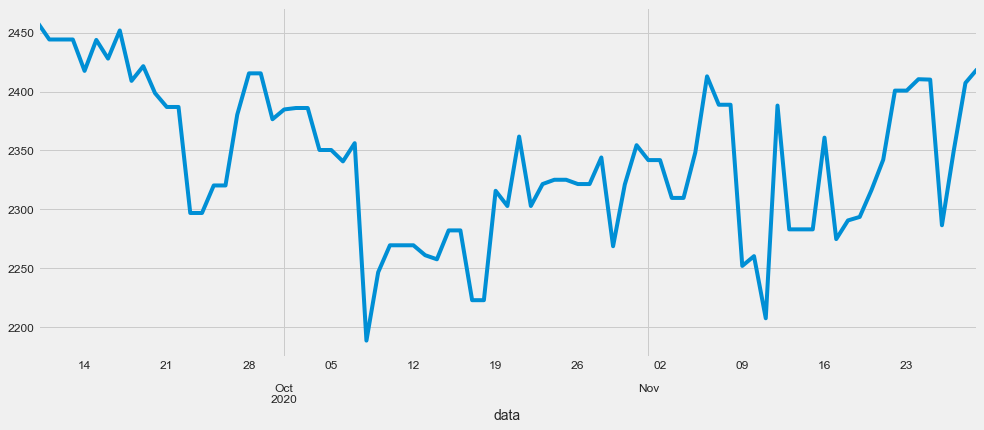

In [106]:
y.plot(figsize=(15,6))
plt.show()

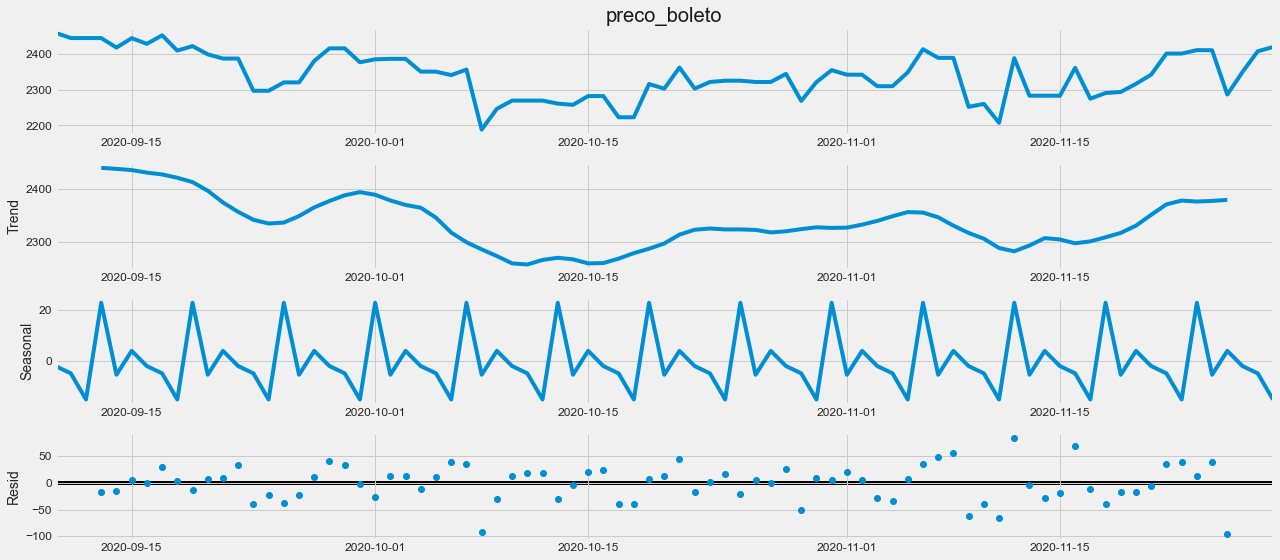

In [107]:
import matplotlib as mpl
rcp = mpl.rcParams
rcp['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=6)
fig = decomposition.plot()
plt.show()

In [100]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [101]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1470.325686073961
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:801.5779580705193
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:648.2295356004547
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:813.2597197041856
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:783.350791326969
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:665.8019098960663
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:633.3551935272985
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1350.4807589082984
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1151.9422330745688
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:768.02158145265
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:617.9056441469672
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:793.4050939353473
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:747.1770437774247
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:647.1208338074164
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:608.7583407182052
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:844.4945209897809
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:724.3159599512188
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:757.1640769839036
ARIMA(0, 1,

In [102]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3893      0.329      1.183      0.237      -0.256       1.034
ma.L1         -0.7567      0.230     -3.288      0.001      -1.208      -0.306
ar.S.L12      -0.4937      0.207     -2.384      0.017      -0.900      -0.088
ma.S.L12      -0.4475      0.241     -1.858      0.063      -0.919       0.024
sigma2      2727.7724    559.620      4.874      0.000    1630.937    3824.608


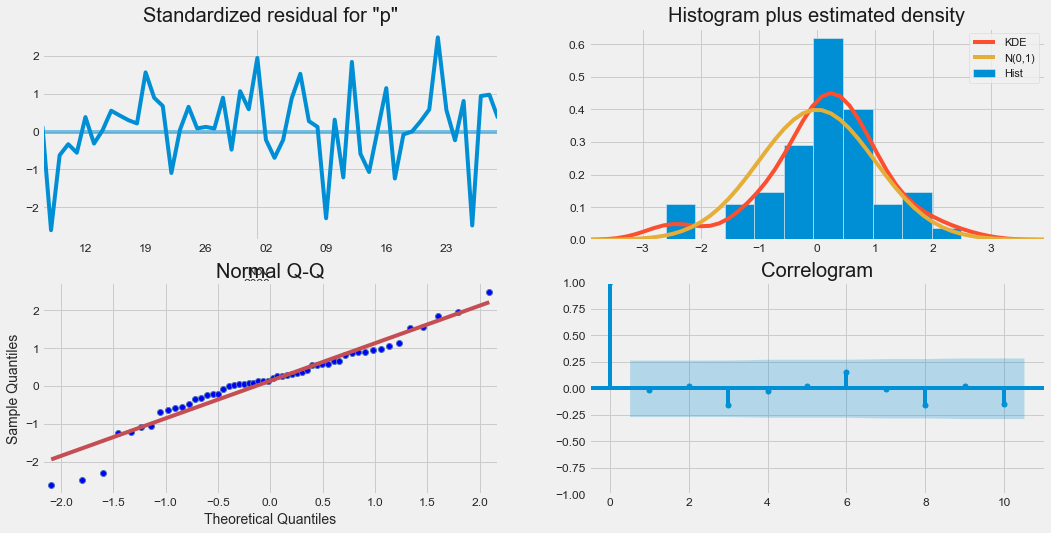

In [108]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

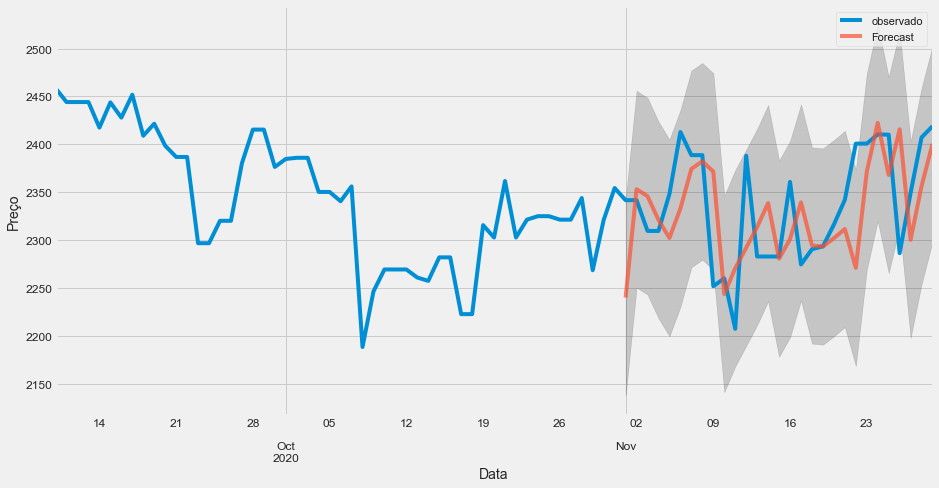

In [120]:
pred = results.get_prediction(start=pd.to_datetime('2020-11-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2020':].plot(label='observado')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
plt.legend()
plt.show()

In [117]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-09-10':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3555.82


In [118]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 59.63


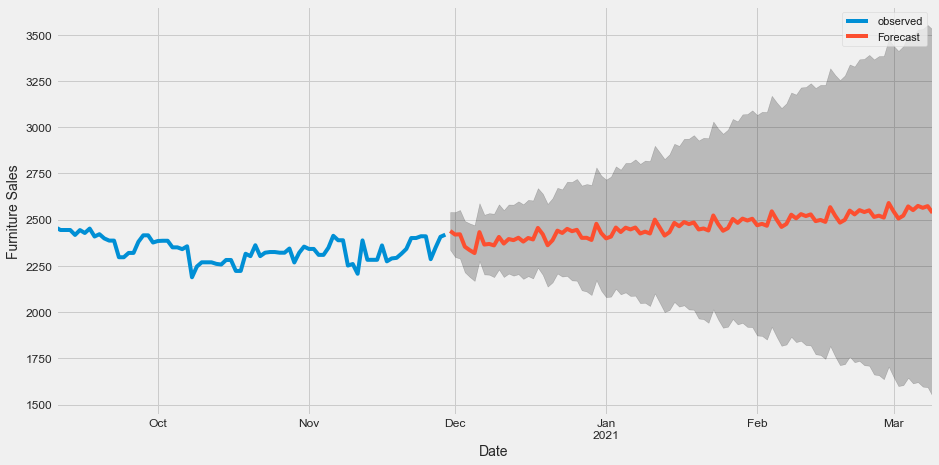

In [119]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observado', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# Seção de teste

In [79]:
# analise = analise[["data", "preco_boleto"]]

# analise = analise.rename(columns = {"data":"ds","preco_boleto":"y"}) #renaming the columns of the dataset
# analise.head(5)

In [209]:
placa = analise.groupby('data')['preco_boleto'].mean().reset_index()
# placa = analise
placa = placa[['data', 'preco_boleto']]
# start_date = "2020-11-01"
# end_date = "2020-11-28"
# after_start_date = placa['data'] >= start_date
# before_end_date = placa['data'] <= end_date
# between_two_dates = after_start_date & before_end_date
# placa = placa.groupby('data').mean()
placa.set_index('data', inplace=True)
# placa = placa[~placa.index.duplicated(keep='first')]
# placa.reset_index(inplace=True)
placa

,preco_boleto
data,
2020-09-10,2458.640741
2020-09-11,2444.196296
2020-09-13,2444.196296
2020-09-14,2417.529630
2020-09-15,2443.825926
...,...
2020-11-24,2410.448387
2020-11-25,2410.118750
2020-11-26,2286.393250


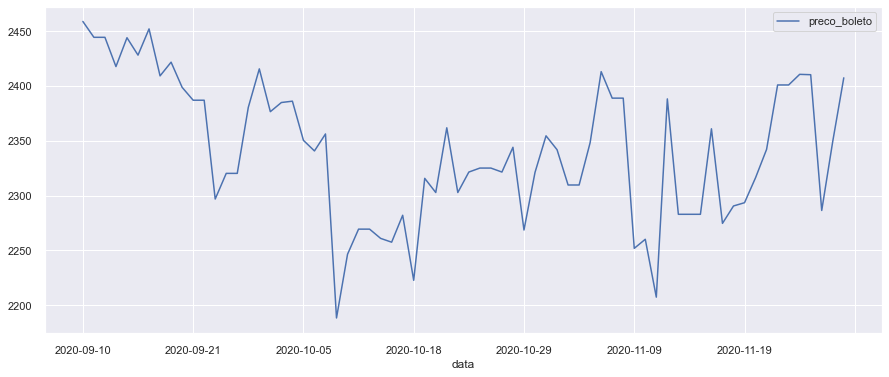

In [140]:
placa.plot(figsize=(15, 6))
plt.show()

In [82]:
# plt.rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(y, model='additive')
# fig = decomposition.plot()
# plt.show()

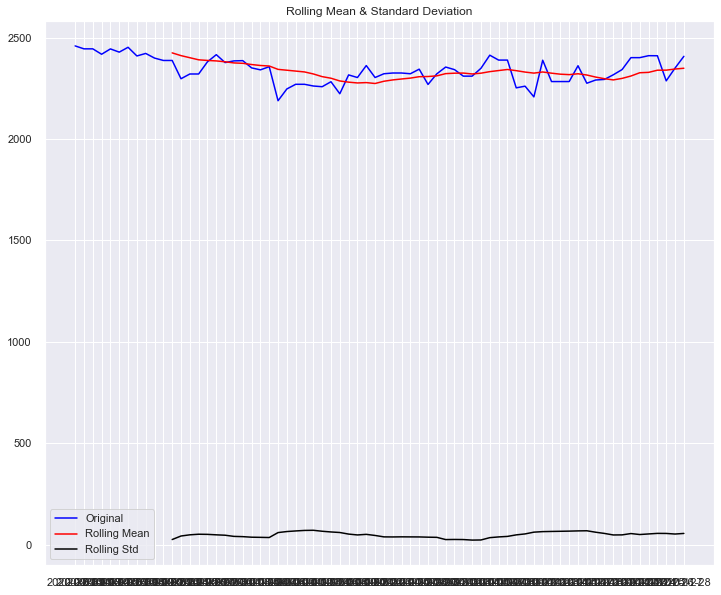

Results of Dickey-Fuller Test:
Test Statistic                 -4.053113
p-value                         0.001157
#Lags Used                      0.000000
Number of Observations Used    69.000000
Critical Value (1%)            -3.528890
Critical Value (5%)            -2.904440
Critical Value (10%)           -2.589656
dtype: float64


In [141]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(placa)

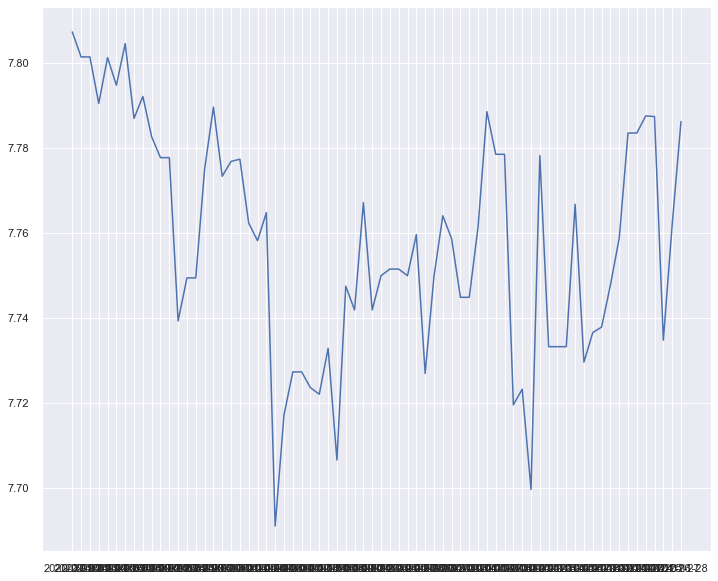

In [142]:
ts_log = np.log(placa)
plt.plot(ts_log);

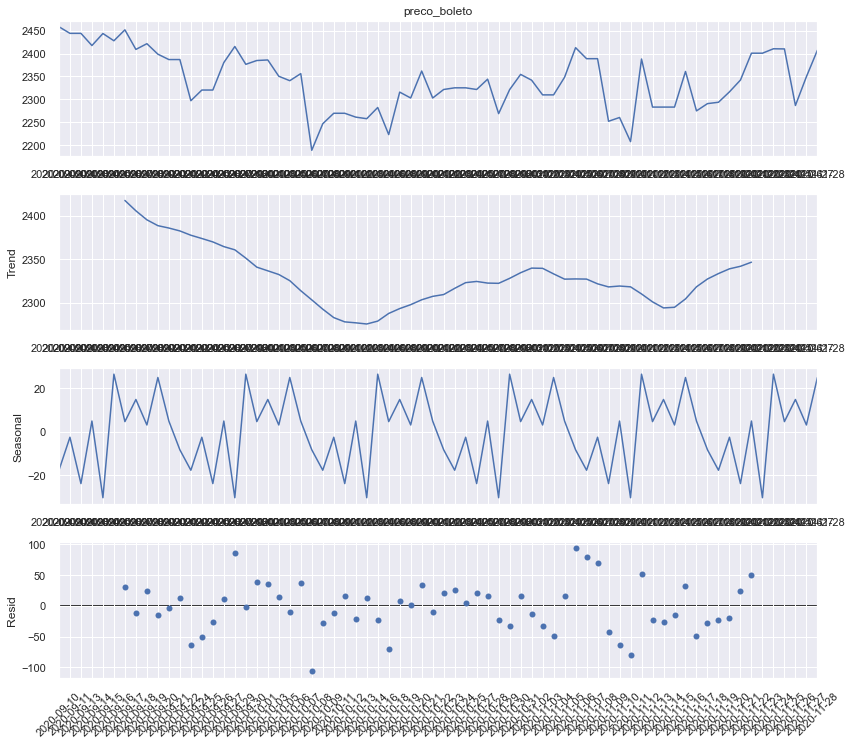

In [143]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(placa['preco_boleto'], freq=12)
decomposition.plot()
plt.xticks(rotation = 45)
plt.show()

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

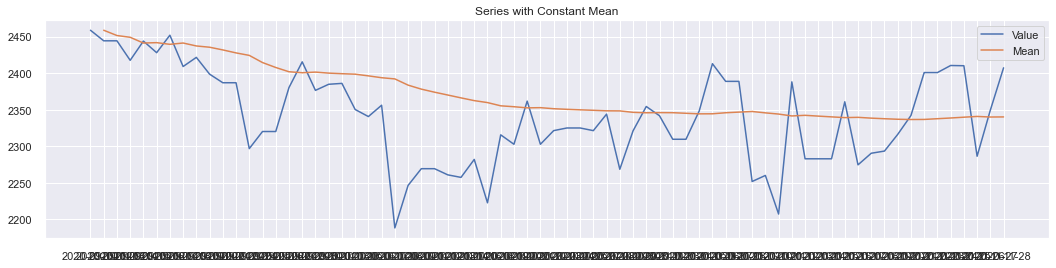

In [216]:
mean = [np.mean(placa[:x]) for x in range(len(placa))]
plt.figure(figsize=(18,4))
plt.plot(placa, label='Value')
plt.plot(mean, label='Mean')
plt.title('Series with Constant Mean')
plt.legend()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, 2020-09-10 to 2020-11-28
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   preco_boleto  70 non-null     float64
dtypes: float64(1)
memory usage: 1.1+ KB


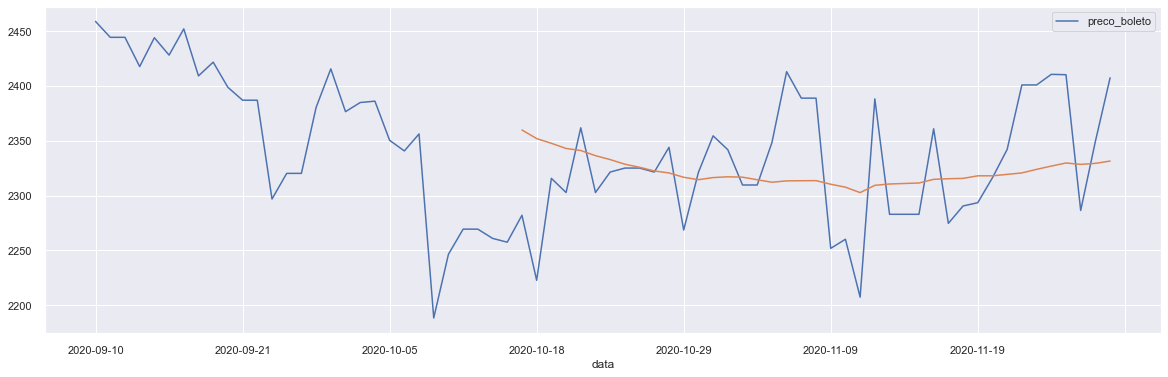

In [213]:

placa.plot(figsize=(20,6))
placa.rolling(window=30).mean()['preco_boleto'].plot()
# placa = placa.asfreq('d')
placa.info()
train_df = placa.iloc[:60]
test_df = placa.iloc[59:]

In [214]:
train_df.shape, test_df.shape

((60, 1), (11, 1))

<AxesSubplot:xlabel='data'>

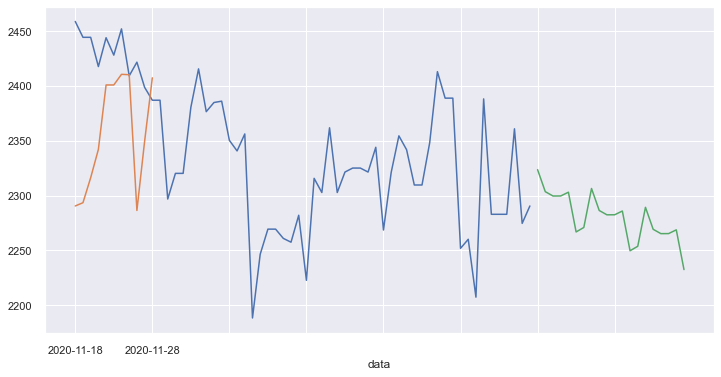

In [215]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
fit_model = ExponentialSmoothing(train_df['preco_boleto'], trend='add', seasonal='add', seasonal_periods=7).fit()
prediction = fit_model.forecast(20)
train_df['preco_boleto'].plot(figsize=(12,6))
test_df['preco_boleto'].plot()
prediction.plot()

In [38]:
df.to_excel('Dados.xlsx')